<h1 style="font-size:30px;text-align: center;">- Machine Learning Methods  - Final Project -</h1>
<h1 style="font-size:25px;text-align: center;">- Credit Card Fraud Classification -</h1>

![Algebra](https://repozitorij.algebra.hr/sites/repozitorij.algebra.hr/files/algebra_subbrand_vu_color-black_h_1.png)

=========================================================================================================================
<b>*Made: July 2021.* </b>

<b>*Author: Mislav Spajić, univ. bacc. ing. agr.*</b>

<b>*Menthors: Lovro Sindičić, mag. educ. math. et inf. & Matej Duvnjak, mag. inf. et math*</b>

## Table of Contents

[1. Introduction](#introduction)
   > [1.1. Goal of the project](#goal)   
   > [1.2. Problem description](#problem)    
   > [1.3. Dataset description](#dataset)
   

[2. Prerequisites](#prereq)


[3. Initial data preparation](#dprep)
    
   > [3.1. Importing data](#data)  
   > [3.2. Missing values](#miss)   
   > [3.3. Train - test split](#ttsplit)    

[4. Exploratory data analysis](#eda)

   > [4.1. Response variable distribution](#response)  
   > [4.2. Input variables distribution](#input)    
   > [4.3. Input variables correlation](#cc)
   
[5. Model development](#model)

   > [5.1. Defining Pipeline](#pipe)   
   > [5.2. Base models](#base)    
   > [5.3. Optimizing hyperparameters](#hyper)       
   > [5.4. Final evaluation - on test set](#final)
   

   
[6. Project conclusion](#conclusion) 

---------------------------------------------------------------------
   

## 1. Introduction<a name="introduction"></a>

### 1.1. Goal of the project<a name="goal"></a>

&nbsp;&nbsp;&nbsp;&nbsp;Goal of this final student project was to successfully apply knowledge learnt in the class 'Machine Learning Methods' on a chosen dataset. In particular, data splitting and preparation, application of various machine learning algorithms, cross-validation and tuning of the hyperparameters, constructing and using machine learning pipelines, evaluation of the trained models, etc.

### 1.2. Problem description<a name="problem"></a>

&nbsp;&nbsp;&nbsp;&nbsp;Usage of credit cards on the internet has been rapidly growing in the past twodecades and today it is the de facto standard of the internet shopping. It is important that credit card companies are able to recognize fraudulent redit card transactions so that customers are not charged for items that they did not purchase. Many anonymized datasets of credit card transaction data are offered on the internet so people can try to tackle this issue by successfully classifying fraudulent and non-fraudulent transaction using given features.

&nbsp;&nbsp;&nbsp;&nbsp;In this case we are dealing with binary classification problem. Class distribution of response variable of the chosen dataset is highly imbalanced, so I will need to tackle this issue.

### 1.3. Dataset description<a name="dataset"></a>

&nbsp;&nbsp;&nbsp;&nbsp;I will be using "Credit Card Fraud Detection" credited to the Machine Learning Group at the Free
University of Brussel. 

&nbsp;&nbsp;&nbsp;&nbsp;Data was obtained from this link : https://www.kaggle.com/mlg-ulb/creditcardfraud.

&nbsp;&nbsp;&nbsp;&nbsp;The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is
highly imbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, author of the dataset couldn’t provide the original features and more background information
about the data. 

&nbsp;&nbsp;&nbsp;Features V1, V2, . . ., V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are "Time" and "Amount". Feature "Time" contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature "Amount" is the transaction amount. 

&nbsp;&nbsp;&nbsp;Column "Class" is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# 2. Prerequisites<a name="prereq"></a>

&nbsp;&nbsp;&nbsp;&nbsp;Importing needed Python libraries & modules and initial setup.

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score,f1_score, recall_score,precision_recall_curve,plot_confusion_matrix
from sklearn.compose import ColumnTransformer

%matplotlib inline 
#Jupyter inline magic command needed to display plots
plt.style.use("ggplot")
#Setting different plot style than default, using ggplot style derived from famous R library ggplot2
plt.style.use('seaborn-poster') 
#sets the size of the charts
seed=42
#Defining seed variable to use in algorithms which rely on randomness, this is for reproducibility

# 3. Initial data preparation<a name="dprep"></a>

## 3.1. Importing data<a name="data"></a>

In [2]:
#Importing the data and checking how does it look
data=pd.read_csv("creditcard.csv")
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3.2. Missing values<a name="miss"></a>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Lucikly, there are no missing values in this dataset.

## 3.3. Train - test split<a name="ttsplit"></a>

I will split the data into train and test sets in 70-30 % ratio. For validation purposes I will utilize cross-validation.

In [4]:
# Very important is to use stratify parameter to have the exact response variable class distributions in both sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns="Class"),
                                                    data["Class"], stratify=data["Class"], test_size=0.3,random_state = seed)

# 4. Exploratory data analysis<a name="eda"></a>

As I have said before, the response variable classes are highly imbalanbced, lets check their distribution.

In [5]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [6]:
y_train.value_counts(normalize=True)

0    0.998275
1    0.001725
Name: Class, dtype: float64

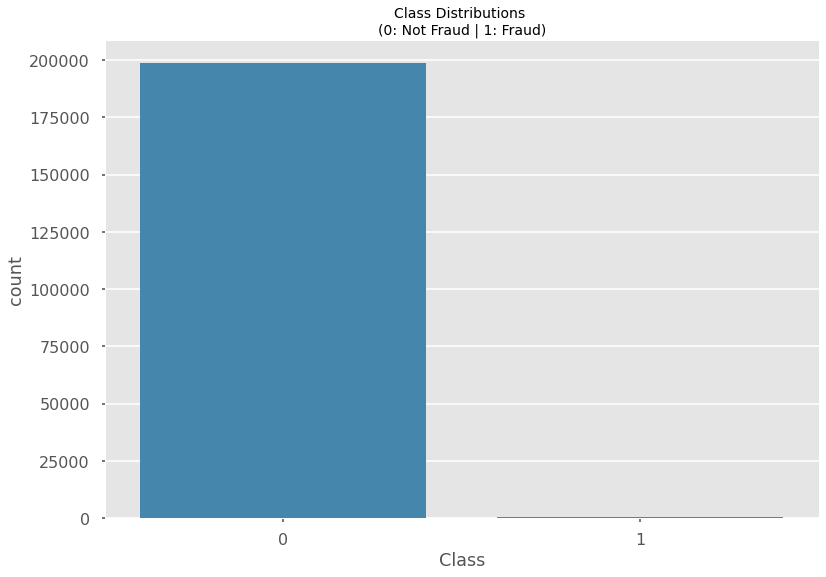

In [7]:
sns.countplot(x=y_train, palette=["#348abd","#e24a33"])
plt.title('Class Distributions \n(0: Not Fraud | 1: Fraud)', fontsize=14)
plt.show()

## 4.2. Input variables distribution<a name="input"></a>

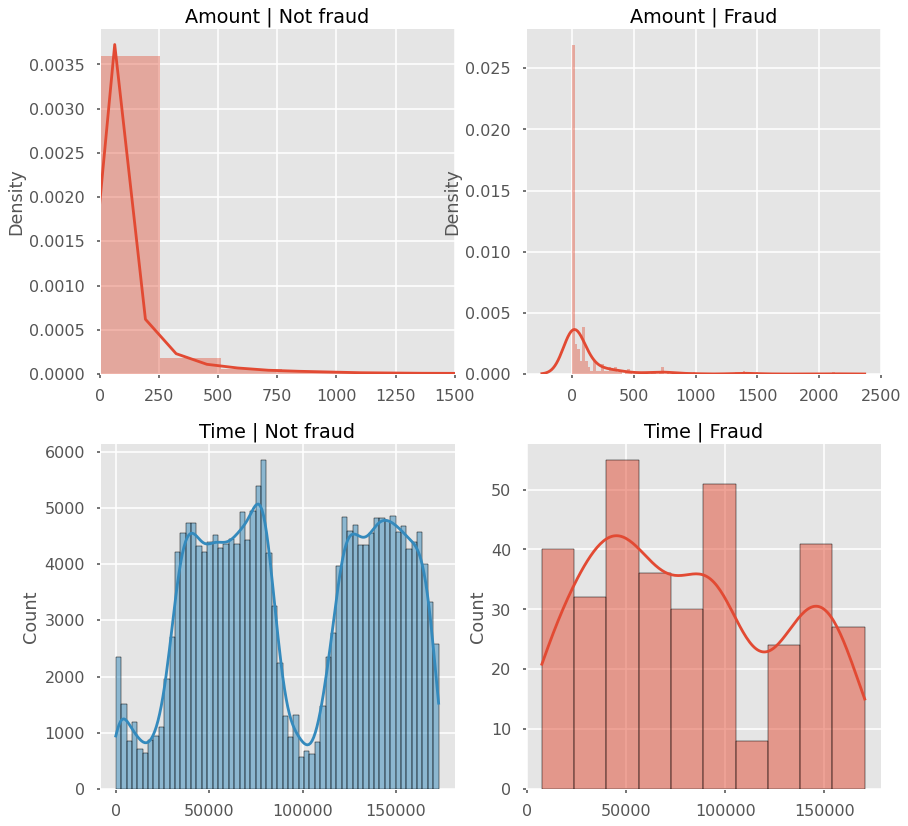

In [8]:
plt.figure(figsize=(14,14))
plt.subplot(221)
sns.distplot(X_train[y_train == 0].Amount.values, kde = True, bins=100)
plt.title('Amount | Not fraud')
plt.xlim([0, 1500])
plt.subplot(222)
sns.distplot(X_train[y_train == 1].Amount.values, kde = True, color ="#e24a33", bins=100)
plt.title('Amount | Fraud')

plt.subplot(223)
sns.histplot(X_train[y_train == 0].Time.values, kde = True,ec="black")
plt.title('Time | Not fraud')
plt.subplot(224)
sns.histplot(X_train[y_train == 1].Time.values, kde = True,ec="black", color ="#e24a33")
plt.title('Time | Fraud')
plt.show()

This shows us these features could be useful, there is some distinction in the distributions of these features in fraud and not fraud cases.

In case of Amount we can notice that fraud cases are generally lower amount.

Time in case of not fraud is distributed in logical day-night seasonality manner while in case of fraud cases distribution of this feature is more uniform, although this could be because of the much smaller number of fraud cases compared to non-fraud.


This graph shows that most of the fraud transaction amount is less than 500 dollars. This also shows that the fraud transaction is very high for an amount near to 0, let's find that amount.

In [9]:
print("Fraud Transaction distribution : \n",X_train[y_train == 1].Amount.value_counts().head())
print("\n")
print("Maximum amount of fraud transaction - ",X_train[y_train == 1].Amount.max())
print("Minimum amount of fraud transaction - ",X_train[y_train == 1].Amount.values.min())

Fraud Transaction distribution : 
 1.00     82
0.00     19
99.99    17
0.76     15
0.77      5
Name: Amount, dtype: int64


Maximum amount of fraud transaction -  2125.87
Minimum amount of fraud transaction -  0.0


There are 82 fraud transactions for just 1 and 17 fraud transaction for 99.99. And higest fraud transaction amount was 2125.87 and lowest was just 0.00.

There are 19 fraud transaction for zero amount. Zero Authorization is an account verification method for credit cards that is used to verify a cardholders information without charging the consumer. Instead, an amount of zero is charged on the card to store the credit card information in the form of a token and to determine whether the card is legitimate or not. After creating the token, is then possible to charge the consumer with a new transaction with either Tokenization or Recurring Payments

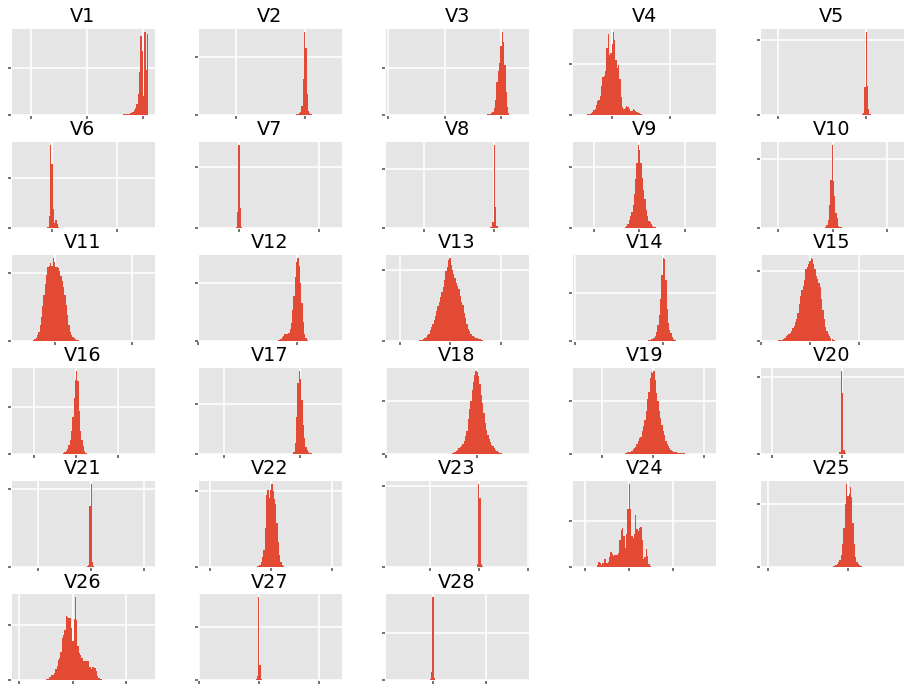

In [10]:
ax = X_train.iloc[:,1:-1].hist(figsize=(16,12),bins=100)
# We hide the axes' labels to make the plot neater and more compact
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

We can see that some of the features are normally distributed, but some aren't so I will use a scaler later on in the ML pipeline.

## 4.3. Input variables correlation<a name="cc"></a>

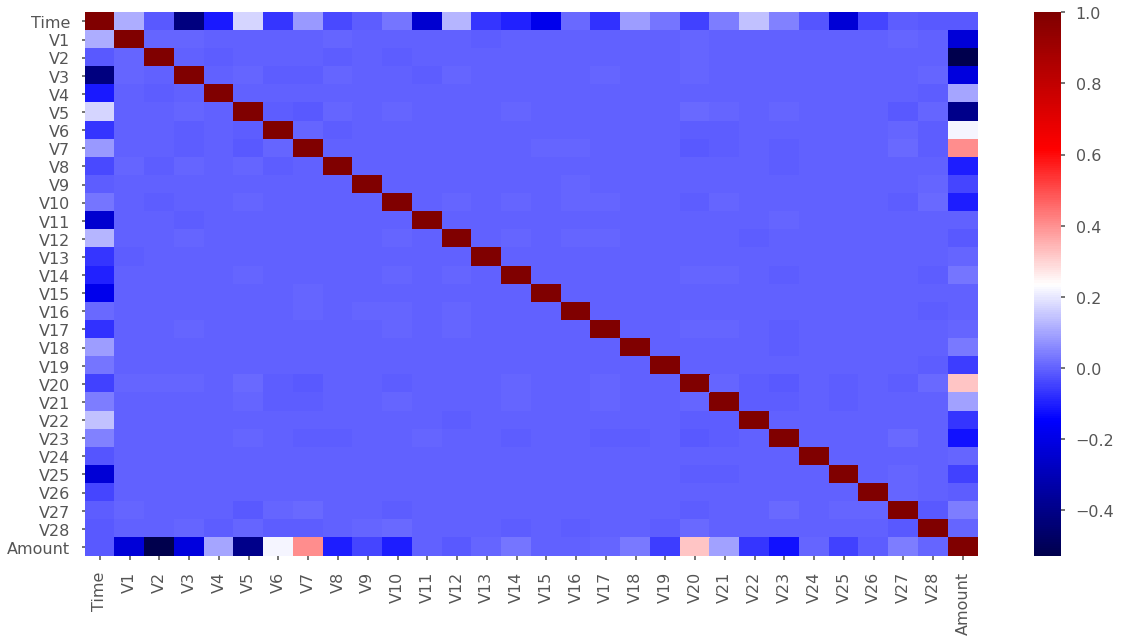

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(data=X_train.corr(), cmap="seismic")
plt.show();

In [12]:
#Getting top correlation values - helper functions
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [13]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train, 6))

Top Absolute Correlations
V2    Amount    0.528697
Time  V3        0.419257
V7    Amount    0.406573
V5    Amount    0.392593
V20   Amount    0.322661
Time  V11       0.246973
dtype: float64


There are only a few features above 0.3, everything below is considered negligible. First pair is just moderatly correlated and in the rest low correlation occurs. Since, these results are like this, we are good to go and I will use all the features.

# 5. Model development<a name="model"></a>

## 5.1. Defining Pipeline<a name="pipe"></a>

In [14]:
# For Time and Amount we use MinMax scaler and for V features robust scaler
scaler = ColumnTransformer(
    transformers=[
        ('scaler1', MinMaxScaler(), ['Time','Amount']),
        ('scaler2', RobustScaler(), X_train.columns.tolist()[1:29])
   ])

# For handling class imblance - SMOTE oversampler
oversampler = SMOTE(random_state=seed,n_jobs=-1)

#Various classification models
LR = LogisticRegression(max_iter=1000,random_state=seed)
kNN = KNeighborsClassifier(n_jobs=-1)
DT = DecisionTreeClassifier()
XGB = XGBClassifier(use_label_encoder=False,eval_metric='aucpr',random_state=seed,n_jobs = -1)
RF = RandomForestClassifier(random_state=seed,n_jobs=-1)



#Define the pipeline
steps = list()
steps.append(('scaler', scaler))
steps.append(('oversampler', oversampler))
steps.append(('classifier', LR))
#LR is just a placeholder

#Initializing imblearn pipeline
pipeline = Pipeline(steps=steps)

In [15]:
names = ['LR','kNN', 'DT','RF','XGB']
classifiers = [LR, kNN, DT, RF,XGB]

## 5.2. Base models<a name="base"></a>

All base models will be trained and evaluated with a 3-fold Stratified CV. Main metrics for evaluation are Recall, Precision and f1 score, as accuracy is not useful because of the imbalance.

In [19]:
splits=3
skf = StratifiedKFold(n_splits=splits)
scores={}
for name, classifier in zip(names, classifiers):
    scores[name]={}
    scores[name]['Recall']=[]
    scores[name]['Precision']=[]
    scores[name]['f1']=[]
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_train_fold, X_valid_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        steps[2]=(('classifier', classifier))
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train_fold, y_train_fold)
        
        scores[name]['Recall'].append(recall_score(y_valid_fold, pipeline.predict(X_valid_fold)))
        scores[name]['Precision'].append(precision_score(y_valid_fold, pipeline.predict(X_valid_fold)))
        scores[name]['f1'].append(f1_score(y_valid_fold, pipeline.predict(X_valid_fold)))

        

C:\Users\Mislav\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Mislav\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Mislav\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Mislav\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  

In [20]:
scores

{'LR': {'Recall': [0.9217391304347826, 0.9304347826086956, 0.8771929824561403],
  'Precision': [0.05751492132392838, 0.06592729513247074, 0.07757951900698215],
  'f1': [0.10827374872318694, 0.12313003452243959, 0.14255167498218105]},
 'kNN': {'Recall': [0.8869565217391304,
   0.8695652173913043,
   0.8245614035087719],
  'Precision': [0.46788990825688076, 0.4149377593360996, 0.42152466367713004],
  'f1': [0.6126126126126126, 0.5617977528089888, 0.5578635014836796]},
 'DT': {'Recall': [0.7217391304347827, 0.808695652173913, 0.7894736842105263],
  'Precision': [0.39712918660287083, 0.375, 0.39823008849557523],
  'f1': [0.5123456790123457, 0.512396694214876, 0.5294117647058824]},
 'RF': {'Recall': [0.8173913043478261, 0.808695652173913, 0.8333333333333334],
  'Precision': [0.8703703703703703, 0.8303571428571429, 0.9134615384615384],
  'f1': [0.8430493273542601, 0.8193832599118942, 0.8715596330275229]},
 'XGB': {'Recall': [0.8521739130434782,
   0.8347826086956521,
   0.8421052631578947],


In [21]:
scores.keys()

dict_keys(['LR', 'kNN', 'DT', 'RF', 'XGB'])

In [22]:
for i in scores.keys():
    print("------------------Model:"+i+"------------------")
    print("%0.2f recall with a standard deviation of %0.2f" %
          (np.array(scores[i]["Recall"]).mean(), np.array(scores[i]["Recall"]).std()))
    print("%0.2f precision with a standard deviation of %0.2f" %
          (np.array(scores[i]["Precision"]).mean(), np.array(scores[i]["Precision"]).std()))
    print("%0.2f f1 with a standard deviation of %0.2f" %
          (np.array(scores[i]["f1"]).mean(), np.array(scores[i]["f1"]).std()))
        

------------------Model:LR------------------
0.91 recall with a standard deviation of 0.02
0.07 precision with a standard deviation of 0.01
0.12 f1 with a standard deviation of 0.01
------------------Model:kNN------------------
0.86 recall with a standard deviation of 0.03
0.43 precision with a standard deviation of 0.02
0.58 f1 with a standard deviation of 0.02
------------------Model:DT------------------
0.77 recall with a standard deviation of 0.04
0.39 precision with a standard deviation of 0.01
0.52 f1 with a standard deviation of 0.01
------------------Model:RF------------------
0.82 recall with a standard deviation of 0.01
0.87 precision with a standard deviation of 0.03
0.84 f1 with a standard deviation of 0.02
------------------Model:XGB------------------
0.84 recall with a standard deviation of 0.01
0.77 precision with a standard deviation of 0.04
0.80 f1 with a standard deviation of 0.02


We can see that the best base models are RF and XGB classifier. The worst ones are Logistic Regression and Decision Tree. Since Logistic Regression has great recall and its training doesnt las long I will include it into hyperparameter optimization, Decision Tree will be excluded.

## 5.3. Optimizing hyperparameters<a name="hyper"></a>

In [23]:
# Defining models that will go into loop for grid search and coresponding parameters
names = ['LR','kNN','RF','XGB']
classifiers = [LR,kNN, RF,XGB]

parameters = [
    {
         
        'classifier__solver' : ['sag','newton-cg','lbfgs'],
        'classifier__C' : [0.01, 0.1, 1, 10]
    },
    {
        
        'classifier__n_neighbors': [3, 4, 5, 6, 7],
        'classifier__p': [1, 2],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        
        'classifier__n_estimators': [100, 200, 400],
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 5, 10, None],
        
    },
    {
        
        'classifier__n_estimators': [100, 150, 200],
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5, 6]
        
    }

]

In [ ]:
scores={}
for name, classifier, params in zip(names, classifiers, parameters):
    scores[name]={}
    print(name)
    start = time.time()
    steps[2]=(('classifier', classifier))
    pipeline = Pipeline(steps=steps)
    gscv = GridSearchCV(pipeline, param_grid=params,  scoring='f1', n_jobs=-1, cv=skf, verbose=2)
    gscv.fit(X_train, y_train)
    scores[name]['Best_Params']=gscv.best_params_
    scores[name]['Best_Score']=gscv.best_score_
    elapsed = (time.time() - start)
    print(time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

I accidentally reran whole notebook so the results aren't fully visible, GridSearchCV took approximately 10 hours to complete. Lucikly, I have saved the best model parameters as text.

```text
{'LR': {'Best_Params': {'classifier__C': 0.01, 'classifier__solver': 'sag'},
  'Best_Score': 0.1301667932735263},
 'kNN': {'Best_Params': {'classifier__n_neighbors': 3,
   'classifier__p': 1,
   'classifier__weights': 'distance'},
  'Best_Score': 0.6846738833335836},
 'RF': {'Best_Params': {'classifier__max_depth': None,
   'classifier__min_samples_split': 2,
   'classifier__n_estimators': 400},
  'Best_Score': 0.851732624213402},
 'XGB': {'Best_Params': {'classifier__max_depth': 6,
   'classifier__min_child_weight': 1,
   'classifier__n_estimators': 200,
   'classifier__subsample': 0.8},
  'Best_Score': 0.814604811152206}}
  ```

In [24]:
#Saving final pipeline - RF classifier
steps[2]=(('classifier', RandomForestClassifier(n_estimators= 400,random_state=seed,n_jobs=-1,max_depth= None, min_samples_split= 2)))
rf_final_pipeline = Pipeline(steps=steps)

## 5.4. Final evaluation - on test set<a name="final"></a>

In [25]:
rf_final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('scaler1', MinMaxScaler(),
                                                  ['Time', 'Amount']),
                                                 ('scaler2', RobustScaler(),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28'])])),
                ('oversampler', SMOTE(n_jobs=-1, random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                               

In [26]:
print("Recall on test set is:", recall_score(y_test, rf_final_pipeline.predict(X_test)))
print("Precision on test set is :", precision_score(y_test, rf_final_pipeline.predict(X_test)))
print("f1 score on test set is:", f1_score(y_test, rf_final_pipeline.predict(X_test)))

Recall on test set is: 0.7905405405405406
Precision on test set is : 0.8602941176470589
f1 score on test set is: 0.823943661971831


In [27]:
y_pred_prob=rf_final_pipeline.predict_proba(X_test)[:,1]

In [28]:
# precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

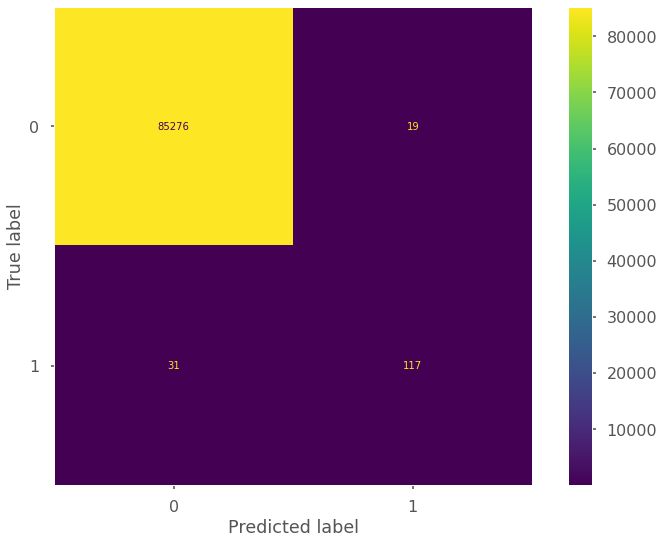

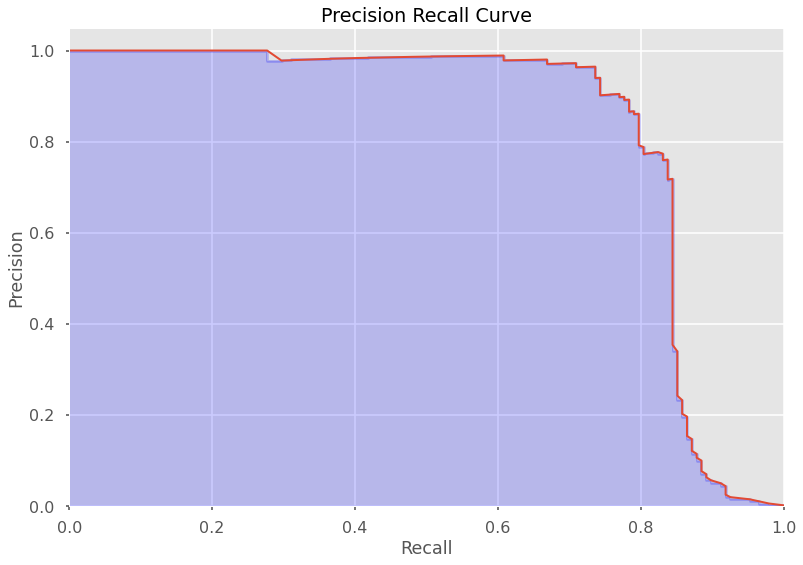

In [29]:
# Confusion Matrix 
plot_confusion_matrix(rf_final_pipeline, X_test, y_test)
plt.grid(False)
plt.show()  


#precision recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plot_precision_recall()

# 6. Project conclusion<a name="conclusion"></a> 

&nbsp;&nbsp;&nbsp;&nbsp;Although I had some experience in exploratory data analysis and machine learning projects, this was my first more detailed one and I am very happy with the result in terms of knowledge gathered while doing it. It was interesting trying to tackle class imbalance problem in binary classification.

&nbsp;&nbsp;&nbsp;&nbsp;Final f1 score of 0.82 of the best model developed (Random Forest based) isn't the best but it isn't terrible either. It was interesting to see that Random Forest outperformed XGB classifier even with tuned hyperparameters.